# D(St)reams of Anomalies

## Introduction

The dataset used in this project (linked below) contains a collection of Twitter mentions for the company Apple Inc. From the data's README: "The metric value represents the number of mentions for a given ticker symbol every 5 minutes." Each observation consists of a timestamp and a value. The timestamp is a 5 minute time block, and the value is the number of twitter mentions Apple got during that time block. The purpose of this project is to use anomaly detection to determine any anomalies in the series of twitter mentions. For this dataset, I expect there to be point anomalies (ie single observations that stand out from the rest). For instance, if Apple is releasing a new iPhone, it is possible there will be an inordinate number of Twitter mentions in the 5 minute intervals leading up to and after the release.

In [335]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

import warnings
warnings.filterwarnings("ignore")

## Data

First I read in the data and print the datafram to see the layout. There are 15,902 observations, meaning there are 15,902 5 minute interval blocks during which Twitter mentions were measured.

In [378]:
df=pd.read_csv("/Users/anissakhan/Dropbox/Nissa_stuff/KU_CS/EECS731/731-Project-6-Khan/Data/RawData/Twitter_volume_AAPL.csv")
df

,timestamp,value
0,2015-02-26 21:42:53,104
1,2015-02-26 21:47:53,100
2,2015-02-26 21:52:53,99
3,2015-02-26 21:57:53,154
4,2015-02-26 22:02:53,120
...,...,...
15897,2015-04-23 02:27:53,44
15898,2015-04-23 02:32:53,45
15899,2015-04-23 02:37:53,48
15900,2015-04-23 02:42:53,26


In [337]:
df.dtypes

timestamp    object
value         int64
dtype: object

The number of twitter mentions within a 5 minute interval range from 0 mentions in 5 minutes, all the way up to 13,479 mentions in 5 minutes. 

In [338]:
df.describe()

,value
count,15902.000000
mean,85.552320
std,321.050721
min,0.000000
25%,29.000000
50%,47.000000
75%,76.000000
max,13479.000000


As seen below, there are no non-null values in our dataset, therefore we don't need to worry about accounting for any missing values.

In [339]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15902 entries, 0 to 15901
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   timestamp  15902 non-null  object
 1   value      15902 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 248.6+ KB


In addition to reading in the dataset as a normal dataframe, I also want to read it in as a time series dataset so that plotting the data is more efficient. As seen below, our timestamp is now the index for the dataset.

In [379]:
dfTime=pd.read_csv('/Users/anissakhan/Dropbox/Nissa_stuff/KU_CS/EECS731/731-Project-6-Khan/Data/RawData/Twitter_volume_AAPL.csv', index_col ='timestamp', parse_dates = True)

In [341]:
dfTime.head()

,value
timestamp,
2015-02-26 21:42:53,104
2015-02-26 21:47:53,100
2015-02-26 21:52:53,99
2015-02-26 21:57:53,154
2015-02-26 22:02:53,120


Next I plot the series. Here we can see the data ranges from March 2015 to late April 2015. Although our data only ranges a month and a half, there are many observations to work with because the frequency of measurement is high (every 5 minutes). A visual inspection of the plot shows us that twitter mentions remain relatively constant (average of 85, as seen earlier), but spike at certain points of the month, with the highest peak occuring around April 1, 2015. A review of news articles and Wikipedia pages indicates there were Macbooks released in March and April of 2015. 

Text(0, 0.5, '# of Mentions')

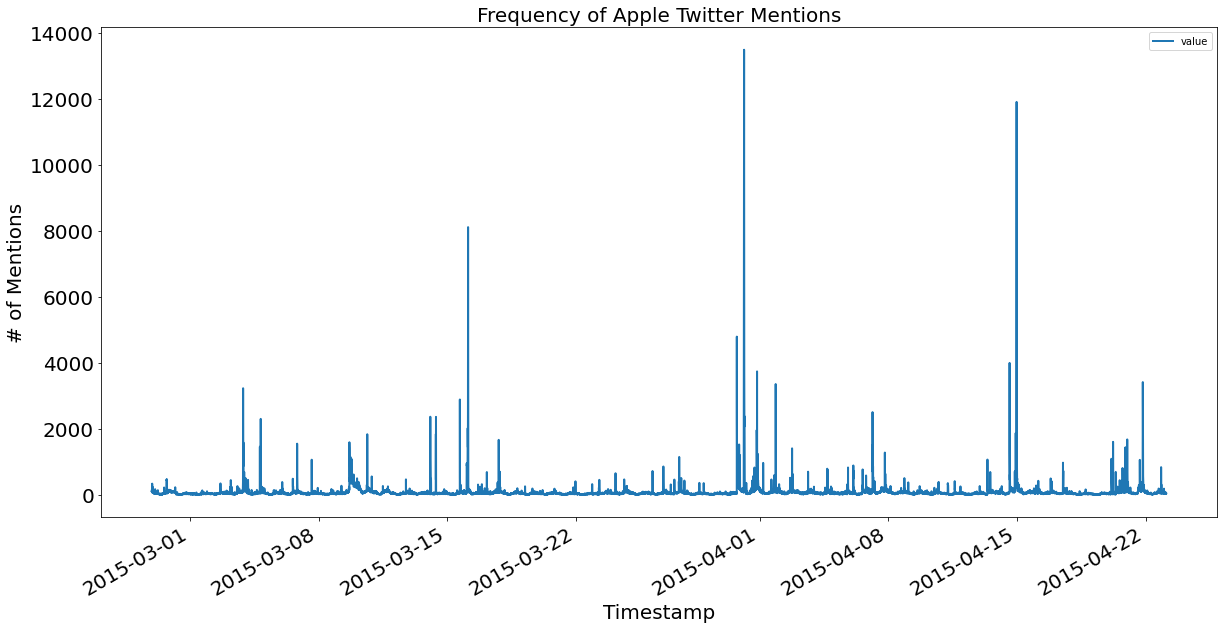

In [342]:
dfTime.plot(figsize=(20,10), linewidth=2, fontsize=20)
plt.xlabel('Timestamp', fontsize=20);
plt.title('Frequency of Apple Twitter Mentions', fontsize=20)
plt.ylabel('# of Mentions', fontsize=20)

## Anomaly Detection

### Isolation Forest

Here I will use a both Isolation Forest and DBSCAN to detect anomalies in the data. First I do an Isolation Forest analysis without a plot. I will plot the same model after this initial analysis. 

In [360]:
from sklearn.ensemble import IsolationForest

In [361]:
model=IsolationForest(n_estimators=50, max_samples=2000, contamination='auto',max_features=1.0)
model.fit(df[['value']])

IsolationForest(max_samples=2000, n_estimators=50)

As we can see, the Isolation Forest algorithm allows us to add new features to the dataset. An anomaly score, and an anomaly value. The anomaly value is 1 if the algorithm marked that observation as normal, and a -1 if the algorithm marked that observation as an anomaly.

In [362]:
df['scores']=model.decision_function(df[['value']])
df['anomaly']=model.predict(df[['value']])
df.head(10)

,timestamp,value,scores,anomaly
0,2015-02-26 21:42:53,104,0.068150,1
1,2015-02-26 21:47:53,100,0.062108,1
2,2015-02-26 21:52:53,99,0.064453,1
3,2015-02-26 21:57:53,154,0.015763,1
4,2015-02-26 22:02:53,120,0.049557,1
5,2015-02-26 22:07:53,90,0.084351,1
6,2015-02-26 22:12:53,92,0.072179,1
7,2015-02-26 22:17:53,71,0.091376,1
8,2015-02-26 22:22:53,339,-0.075283,-1
9,2015-02-26 22:27:53,178,-0.004984,-1


We can print some of these anomaly observations to see which values were marked as anomalies. Below we can see some of those values in the table: salues as low as 177 are marked as anomalies according to the Isolation Forest we just ran with the chosen parameters.

In [363]:
anomaly=df.loc[df['anomaly']==-1]
anomaly_index=list(anomaly.index)
print(anomaly)

                 timestamp  value    scores  anomaly
8      2015-02-26 22:22:53    339 -0.075283       -1
9      2015-02-26 22:27:53    178 -0.004984       -1
12     2015-02-26 22:42:53    179 -0.010869       -1
13     2015-02-26 22:47:53    245 -0.040038       -1
54     2015-02-27 02:12:53    171 -0.001936       -1
...                    ...    ...       ...      ...
15820  2015-04-22 20:02:53    257 -0.031577       -1
15821  2015-04-22 20:07:53    838 -0.195311       -1
15822  2015-04-22 20:12:53    177 -0.002185       -1
15824  2015-04-22 20:22:53    317 -0.042995       -1
15866  2015-04-22 23:52:53    187 -0.006483       -1

[1124 rows x 4 columns]


In [373]:
outliers_counter = len(df[df['anomaly'] < 1])
outliers_counter

1124

If we want to figure out which observations were marked as outliers, we can count how many observations are larger than a certain threshold and compare that count to the count of outliers marked by the algorithm. Here, I played around with a count value until my "Accuracy" percentage was high. Note, the accuracy percentage is not a measure of model accuracy here, because I am simply guessing which threshold determined by the Isolation Forest. It is more a measure of how accurate my guess is.

Overall, we can see there are 1196 observations with a twitter Apple mention count of > 150. The number of anomalies determined by the algorithm is 1124 and 1124/1196=93%. Therefore most of the outliers determined by the algorithm hold values larger than 150. This feels like a very simplistic approach to anomaly detection and can likely be improved by choosing a different model or by improving the parameters chosen. Regardless, we will plot our results to see if they look as we expect them to.

In [370]:
outliers_counter = len(df[df['value'] > 150])
outliers_counter

1196

In [371]:
print("Accuracy percentage:", 100*list(df['anomaly']).count(-1)/(outliers_counter))

Accuracy percentage: 93.9799331103679


### Plotting Isolation Forest

Before plotting the results, I will create another dataset so that I can manipulate the layout of the timestamps so that I am able to plot the data. As a result I will rerun the same Isolation Forest with the same parameters as I did above. Keep in mind the results may be slightly different here because the results are different each time the model is run. However since we use the same parameters they should be very similar.

In [382]:
dfIF=pd.read_csv("/Users/anissakhan/Dropbox/Nissa_stuff/KU_CS/EECS731/731-Project-6-Khan/Data/RawData/Twitter_volume_AAPL.csv")

In [385]:
from sklearn.ensemble import IsolationForest
clf=IsolationForest(n_estimators=50, max_samples=2000, contamination='auto',max_features=1.0)
clf.fit(dfIF[['value']])
pred = clf.predict(dfIF[['value']])
dfIF['anomaly']=pred
outliers=dfIF.loc[dfIF['anomaly']==-1]
outlier_index=list(outliers.index)
#print(outlier_index)
#Find the number of anomalies and normal points here points classified -1 are anomalous
print(dfIF['anomaly'].value_counts())

 1    15014
-1      888
Name: anomaly, dtype: int64


Here I manipulate the timestamp by removing the -, :, and spaces so that the values are plottable. The results of this can be seen below in the dfIF table.

In [386]:
for i in range(0,len(df['timestamp'])):
    dfIF['timestamp'][i] = dfIF['timestamp'][i].replace("-", "")
    dfIF['timestamp'][i] = dfIF['timestamp'][i].replace(":", "")
    dfIF['timestamp'][i] = dfIF['timestamp'][i].replace(" ", "")

In [387]:
dfIF.head()

,timestamp,value,anomaly
0,20150226214253,104,1
1,20150226214753,100,1
2,20150226215253,99,1
3,20150226215753,154,1
4,20150226220253,120,1


I place the feature columns that will be graphed into X.

In [388]:
feature_cols = ['timestamp', 'value']
X = dfIF[feature_cols]
X.head()

,timestamp,value
0,20150226214253,104
1,20150226214753,100
2,20150226215253,99
3,20150226215753,154
4,20150226220253,120


The results of the Isolation Forest can be seen below. It appears as we expected: certain values above a threshold are marked as anomalies by the Isolation Forest. The green observations are marked as normal points while the anomalies are marked as orange points. Even though the anomalies are consistently predicted, this measure of anomaly detection seems too simple. As discussed earlier, detection could be improved by choosing a different model or by improving the parameters chosen. 

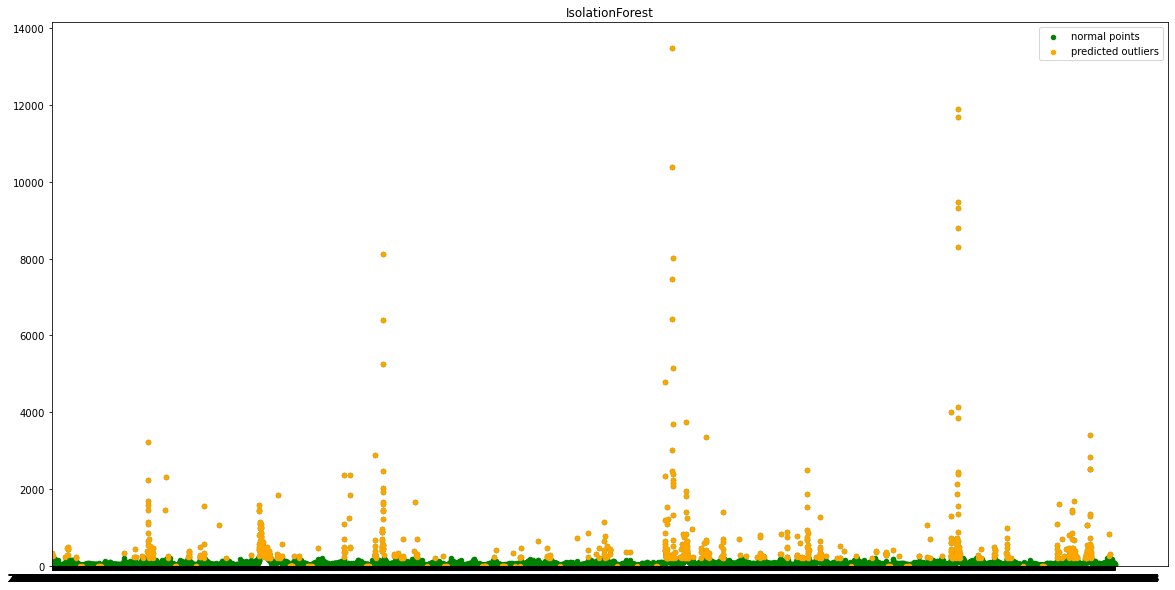

In [389]:
Z = np.array(X)
plt.figure(figsize=(20,10))
plt.title("IsolationForest")
plt.contourf( Z, cmap=plt.cm.Blues_r)
b1 = plt.scatter(X['timestamp'], X['value'], c='green', s=20,label="normal points")
b1 =plt.scatter(X.iloc[outlier_index,0],X.iloc[outlier_index,1], c='orange',s=20,  edgecolor="orange",label="predicted outliers")
plt.legend(loc="upper right")
plt.show()

### DBSCAN for Anomaly Detection

DBSCAN can be used for anomaly detection because it clusters the data. Any observations that are not included in a cluster can be considered anomalies. I run DBSCAN on the data a few times with differing parameters.

The first function below is used to generate the color vectors used for my cluster graphs. In the DBSCAN plots, the noise values are always colored black. It uses random number generators to generate the rbg colors used.

The last function definition is used to scale and normalize the data. As discussed in the clustering project, I normalize the variables I want to use. First I place them in a renamed dataframe dfTest, then scale the data, and then I normalized the dataframe so that it follows a Gaussian distribution. I wanted to scale the data so that the parameters used for DBSCAN affect both variables equally (i.e. the eps value).

In [407]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import normalize 
import random

In [397]:
def genColorsDBSCAN(n_clusters_):
    colors={}
    r = 0
    b = 0
    g = 0
    color = (r, g, b)

    colors[-1]=(0,0,0)
    for i in range(0,n_clusters_):
        r = random.random()
        b = random.random()
        g = random.random()
        color = (r, g, b)
        colors[i]=color
    
    cvec=[colors[label] for label in labels]
    return cvec

In [414]:
def genColorsSingleColor(n_clusters_):
    colors={}
    r = 0
    b = 0
    g = 0
    color = (r, g, b)

    colors[-1]=(0,0,0)
    for i in range(0,n_clusters_):
        r = 0.64706
        b = 0.65490
        g = 0.96863
        color = (r, g, b)
        colors[i]=color
    
    cvec=[colors[label] for label in labels]
    return cvec

In [398]:
def scaleAndNormalize(var1, var2):
    # Scaling the data to bring all the attributes to a comparable level 
    scaler = StandardScaler() 
    dfTest_scaled = scaler.fit_transform(dfTest) 
  
    # Normalizing the data so that  
    # the data approximately follows a Gaussian distribution 
    dfTest_normalized = normalize(dfTest_scaled) 
  
    # Converting the numpy array into a pandas DataFrame 
    dfTest_normalized = pd.DataFrame(dfTest_normalized)
    dfTest_normalized

    dfTest_normalized.columns = [var1, var2]
    return dfTest_normalized

The below data is the normalized and scaled data. This data will be used to run the DBSCAN model. Once the algorithm is run, I will plot the raw data so that the results are interpretable.

In [401]:
dfTest=dfIF[['value', 'timestamp']]

dfTest_normalized=scaleAndNormalize('value', 'timestamp')
dfTest_normalized.head()

,value,timestamp
0,0.024345,-0.999704
1,0.019068,-0.999818
2,0.017749,-0.999842
3,0.089989,-0.995943
4,0.045428,-0.998968


I run several iterations of DBSCAN with varying parameters. In this first model I chose an eps of 0.03 and min_samples of 20. I wanted there to be a minimum of 20 samples per cluster since the dataset is large. The results are: 9 clusters with 129 noise datapoints. In other words, 129 observations that are anomalies. This is many fewer than the Isolation Forest algorithm.

In [402]:
dbsc = DBSCAN(eps = 0.03, min_samples = 20).fit(dfTest_normalized)
labels = dbsc.labels_
core_samples = np.zeros_like(labels, dtype = bool)
core_samples[dbsc.core_sample_indices_] = True

print(set(labels))

n_clusters_=len(set(labels))
n_noise_=list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

{0, 1, 2, 3, 4, 5, 6, 7, -1}
Estimated number of clusters: 9
Estimated number of noise points: 129


The results of the first DBSCAN model are plotted below. The anomaly datapoints are black. It can be seen, these anomaly datapoints are all focused in the right side of the plot, which corresponds to dates in mid to late April. It also includes a few datapoints in March and the maximum datapoints of value=13479. The results of this plot indicates a collective anomaly-- one that appears as a cluster.

Text(0, 0.5, 'value')

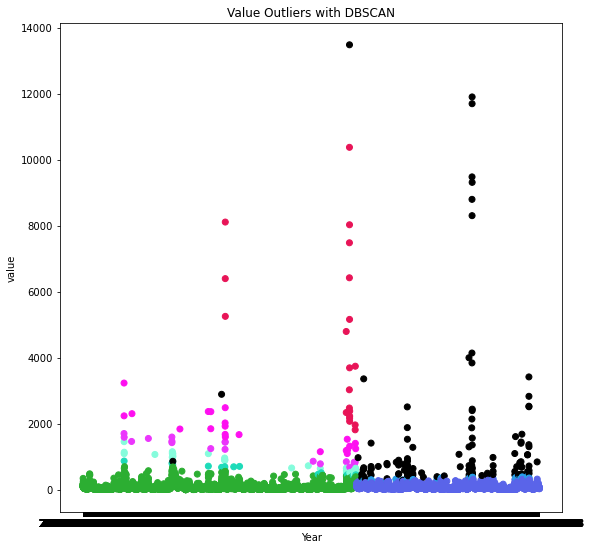

In [403]:
cvec=genColorsDBSCAN(n_clusters_)

plt.figure(figsize=(9,9))
plt.scatter(dfTest['timestamp'], dfTest['value'], c=cvec)
plt.title('Value Outliers with DBSCAN')
plt.xlabel('Year')
plt.ylabel('value')

I next run DBSCAN with a smaller min_samples size (5) to see if some of those anomaly datapoints end up clustered. The result is fewer noise datapoints, which is expected, and more clusters which is also expected.

In [412]:
dbsc = DBSCAN(eps = 0.01, min_samples = 5).fit(dfTest_normalized)
labels = dbsc.labels_
core_samples = np.zeros_like(labels, dtype = bool)
core_samples[dbsc.core_sample_indices_] = True

print(set(labels))

n_clusters_=len(set(labels))
n_noise_=list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, -1}
Estimated number of clusters: 22
Estimated number of noise points: 72


The results are plotted below: my expectation that some of the previous anomaly datapoints would be clustered appears to be correct. Again, the anomaly datapoints are colored black. Despite some of these datapoints being clustered, the noise datapoints are still located on the far right side of the plot, still indicating a collective anomaly.

Text(0, 0.5, 'value')

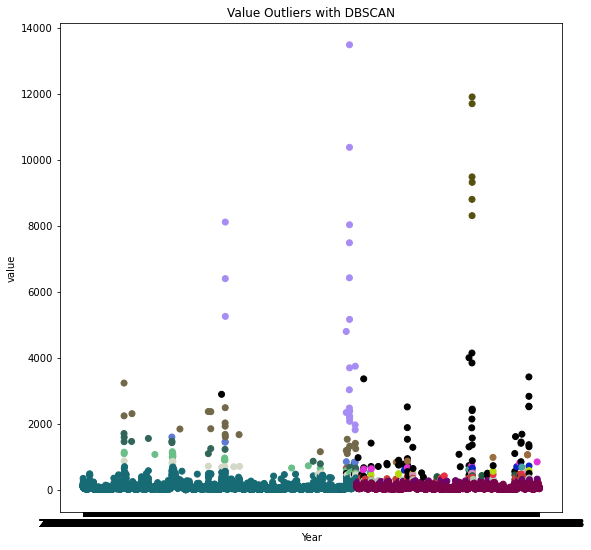

In [410]:
cvec=genColorsDBSCAN(n_clusters_)

plt.figure(figsize=(9,9))
plt.scatter(dfTest['timestamp'], dfTest['value'], c=cvec)
plt.title('Value Outliers with DBSCAN')
plt.xlabel('Year')
plt.ylabel('value')

Below is the same model plotted, with just the anomalies pointed out (in black). All other clusters have the same color. 

Text(0, 0.5, 'value')

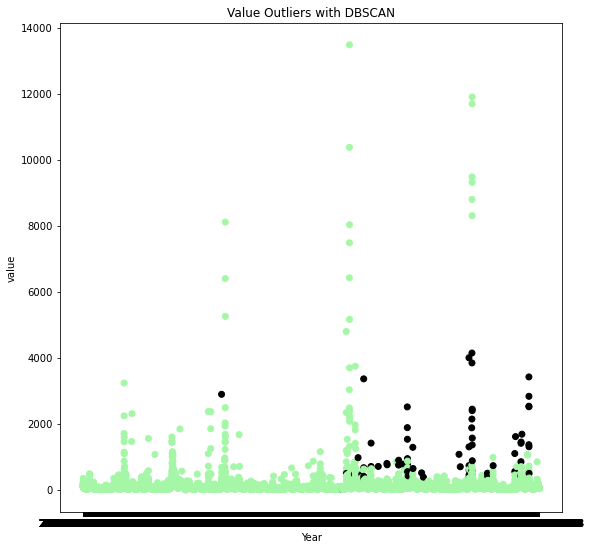

In [415]:
cvec=genColorsSingleColor(n_clusters_)

plt.figure(figsize=(9,9))
plt.scatter(dfTest['timestamp'], dfTest['value'], c=cvec)
plt.title('Value Outliers with DBSCAN')
plt.xlabel('Year')
plt.ylabel('value')

Finally, I try running DBSCAN with the same eps as model 2, but this time with min_samples set to 20 again. The results are more similar to the Isolation Forest results. There are close to 700 anomaly datapoints and 11 clusters.

In [405]:
dbsc = DBSCAN(eps = 0.01, min_samples = 20).fit(dfTest_normalized)
labels = dbsc.labels_
core_samples = np.zeros_like(labels, dtype = bool)
core_samples[dbsc.core_sample_indices_] = True

print(set(labels))

n_clusters_=len(set(labels))
n_noise_=list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, -1}
Estimated number of clusters: 11
Estimated number of noise points: 668


The results are plotted below. These results as mentioned above look very similar to the Isolation Forest results: above a certain threshold, all datapoints are considered anomalies. Again, the black datapoints are the anomaly datapoints.

Text(0, 0.5, 'value')

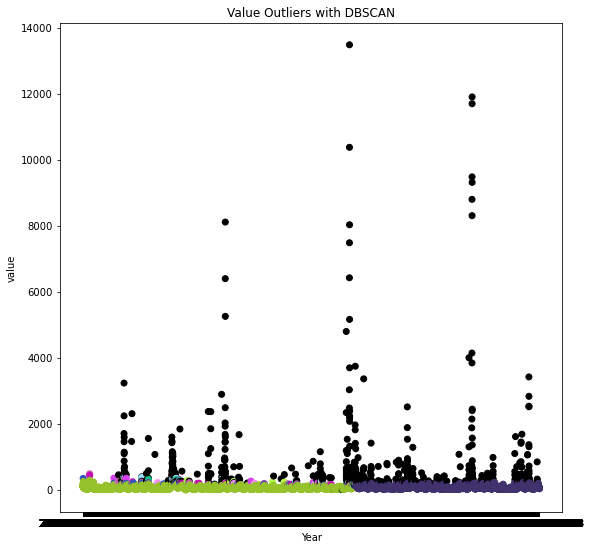

In [406]:
cvec=genColorsDBSCAN(n_clusters_)

plt.figure(figsize=(9,9))
plt.scatter(dfTest['timestamp'], dfTest['value'], c=cvec)
plt.title('Value Outliers with DBSCAN')
plt.xlabel('Year')
plt.ylabel('value')

## Conclusion



I used two algorithms to detect anomalies in the Apple Twitter mentions dataset. These two models were Isolation Forest and DBSCAN. The Isolation Forest results appeared to be too simple, considering all values above a certain threshold to be anomalies.  The DBSCAN results were more varied and resulted in fewer anomaly detections. Further, DBSCAN revealed a possible collective anomaly occuring among observations to the far right of the time series plot. The last DBSCAN plot looked similar to the Isolation Forest results.

Overall, I would like to continue anomaly detection exploration by running more types of models on the data to find results that are robust.